In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,time,temp,rain,wind(m/s),wind_dir,humidity,hPa,snow,mR/h
0,0,2019-01-01 00:00:00,-4.9,0.0,0.4,0,62,1026.9,0.0,0.0105
1,1,2019-01-01 01:00:00,-4.4,0.0,0.6,90,61,1026.7,0.0,0.0106
2,2,2019-01-01 02:00:00,-3.9,0.0,0.4,0,59,1026.7,0.0,0.0106
3,3,2019-01-01 03:00:00,-4.4,0.0,1.0,200,61,1027.2,0.0,0.0106
4,4,2019-01-01 04:00:00,-5.1,0.0,0.7,320,66,1026.7,0.0,0.0105


In [3]:
# time 컬럼의 문자열 데이터를 datetime 타입으로 변환하여 타임스탬프 값으로 변환
df['time'] = pd.to_datetime(df['time']).apply(lambda x: x.timestamp())

In [4]:
scaler = MinMaxScaler()

scale_cols = ['temp','rain','wind(m/s)','wind_dir','humidity','hPa','snow','mR/h']
scaled_df = scaler.fit_transform(df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
print(scaled_df)

          temp  rain  wind(m/s)  wind_dir  humidity       hPa  snow      mR/h
0     0.099558   0.0   0.037736  0.000000  0.600000  0.930233   0.0  0.109375
1     0.110619   0.0   0.056604  0.250000  0.588889  0.926004   0.0  0.125000
2     0.121681   0.0   0.037736  0.000000  0.566667  0.926004   0.0  0.125000
3     0.110619   0.0   0.094340  0.555556  0.588889  0.936575   0.0  0.125000
4     0.095133   0.0   0.066038  0.888889  0.644444  0.926004   0.0  0.109375
...        ...   ...        ...       ...       ...       ...   ...       ...
8732  0.267699   0.0   0.311321  0.694444  0.688889  0.733615   0.0  0.062500
8733  0.241150   0.0   0.301887  0.694444  0.722222  0.750529   0.0  0.062500
8734  0.214602   0.0   0.405660  0.694444  0.677778  0.769556   0.0  0.078125
8735  0.205752   0.0   0.349057  0.750000  0.644444  0.780127   0.0  0.078125
8736  0.199115   0.0   0.320755  0.694444  0.711111  0.782241   0.0  0.078125

[8737 rows x 8 columns]


In [5]:
feature_cols = ['temp','rain','wind(m/s)','wind_dir','humidity','hPa','snow']
result_cols = ['mR/h']

result_df = pd.DataFrame(scaled_df, columns=result_cols)
feature_df = pd.DataFrame(scaled_df, columns=feature_cols)

result_np = result_df.to_numpy()
feature_np = feature_df.to_numpy()

In [6]:
def make_sequence_dataset(feature, result, window_size):
    feature_list = []
    result_list = []
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        result_list.append(result[i+window_size])
        
    return np.array(feature_list), np.array(result_list)

In [7]:
window_size = 40
X,Y = make_sequence_dataset(feature_np, result_np, window_size)
print(X.shape, Y.shape)

(8697, 40, 7) (8697, 1)


In [8]:
split = -400
X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8297, 40, 7) (8297, 1)
(400, 40, 7) (400, 1)


In [9]:
model = Sequential([
    LSTM(128, activation = 'tanh', input_shape = X_train[0].shape),
    Dropout(0.5),
    Dense(1, activation = 'linear')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 랜덤 시드 지정
np.random.seed(5210)
# 모델 컴파일
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# ModelCheckpoint 콜백 생성
checkpoint = ModelCheckpoint('origin_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), callbacks=[checkpoint],batch_size=10)


Epoch 1/50
830/830 [==============================] - 9s 6ms/step - loss: 0.0057 - mae: 0.0505 - val_loss: 0.0014 - val_mae: 0.0296
Epoch 2/50
830/830 [==============================] - 5s 6ms/step - loss: 0.0034 - mae: 0.0375 - val_loss: 0.0012 - val_mae: 0.0258
Epoch 3/50
830/830 [==============================] - 4s 5ms/step - loss: 0.0031 - mae: 0.0349 - val_loss: 0.0012 - val_mae: 0.0279
Epoch 4/50
830/830 [==============================] - 5s 6ms/step - loss: 0.0029 - mae: 0.0338 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 5/50
830/830 [==============================] - 4s 5ms/step - loss: 0.0028 - mae: 0.0331 - val_loss: 0.0014 - val_mae: 0.0291
Epoch 6/50
830/830 [==============================] - 4s 5ms/step - loss: 0.0028 - mae: 0.0329 - val_loss: 0.0011 - val_mae: 0.0255
Epoch 7/50
830/830 [==============================] - 5s 6ms/step - loss: 0.0027 - mae: 0.0322 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 8/50
830/830 [==============================] - 4s 5ms/step - loss: 0.

In [11]:
loss, mae = model.evaluate(X_test, Y_test)
print('Test MSE: {:.5f}'.format(loss))
print('Test MAE: {:.5f}'.format(mae))

13/13 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0316
Test MSE: 0.00166
Test MAE: 0.03163


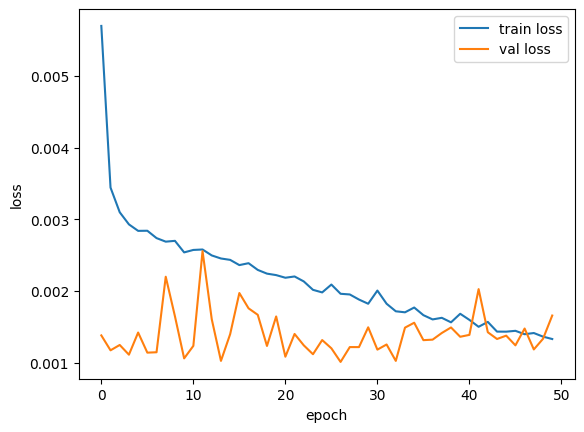

In [12]:
# 로스 감소 그래프 출력
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

13/13 [==============================] - 2s 4ms/step


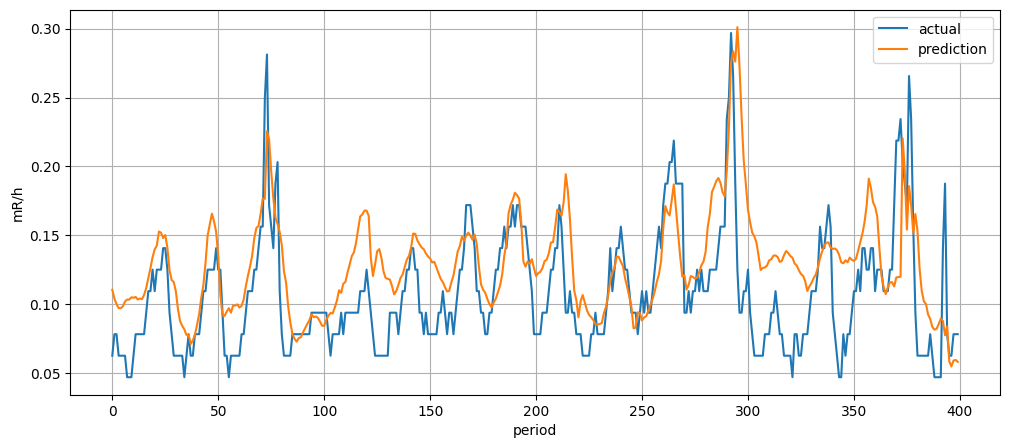

In [13]:
pred = model.predict(X_test)

plt.figure(figsize=(12,5))
plt.xlabel('period')
plt.ylabel('mR/h')
plt.plot(Y_test,label = 'actual')
plt.plot(pred, label = 'prediction')
plt.grid()
plt.legend(loc='best')
plt.show()